Utiliza esta base de datos https://www.kaggle.com/uciml/irisLinks to an external site. para clasificar los diferentes tipos de Iris en base a 2 características, las medidas del sépaloLinks to an external site. y las medidas de los pétalosLinks to an external site., ambos por su ancho y largo.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [2]:
# Crear dataframe
df = pd.read_csv("Iris.csv")
df = df.loc[:,df.columns != 'Id']   # quitamos ID

X = df.loc[:,df.columns != 'Species']
y = df['Species']

# Arbol de Decision

In [3]:
# Rangos de valores para cada clasificacion
setosa_df = df.loc[df['Species'] == 'Iris-setosa']
versicolor_df = df.loc[df['Species'] == 'Iris-versicolor']
virginica_df = df.loc[df['Species'] == 'Iris-virginica']

cols = ["Species", "SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm"]
range_df = pd.DataFrame(columns=cols)

range_df.loc[len(range_df.index)] = ['Iris-setosa'] + [f'({setosa_df[col].min()}, {setosa_df[col].max()})' for col in cols[1:]]
range_df.loc[len(range_df.index)] = ['Iris-versicolor'] + [f'({versicolor_df[col].min()}, {versicolor_df[col].max()})' for col in cols[1:]]
range_df.loc[len(range_df.index)] = ['Iris-virginica'] + [f'({virginica_df[col].min()}, {virginica_df[col].max()})' for col in cols[1:]]

range_df

,Species,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,Iris-setosa,"(4.3, 5.8)","(2.3, 4.4)","(1.0, 1.9)","(0.1, 0.6)"
1,Iris-versicolor,"(4.9, 7.0)","(2.0, 3.4)","(3.0, 5.1)","(1.0, 1.8)"
2,Iris-virginica,"(4.9, 7.9)","(2.2, 3.8)","(4.5, 6.9)","(1.4, 2.5)"


Viendo los rangos de los valores separados por tipo de Iris, vemos que el largo y ancho de pétalo son una hojas puras. Si el largo de pétalo es menor a 1.9 o el ancho del pétalo es menor a 0.6, sabemos que es Setosa. Para las otras especies debemos analizar la ganancia de información.

Luego usamos el DecisionTreeClassifier de SKLearn

In [4]:
irisTree = DecisionTreeClassifier(criterion="entropy", max_depth=5)
irisTree.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], dtype='object')


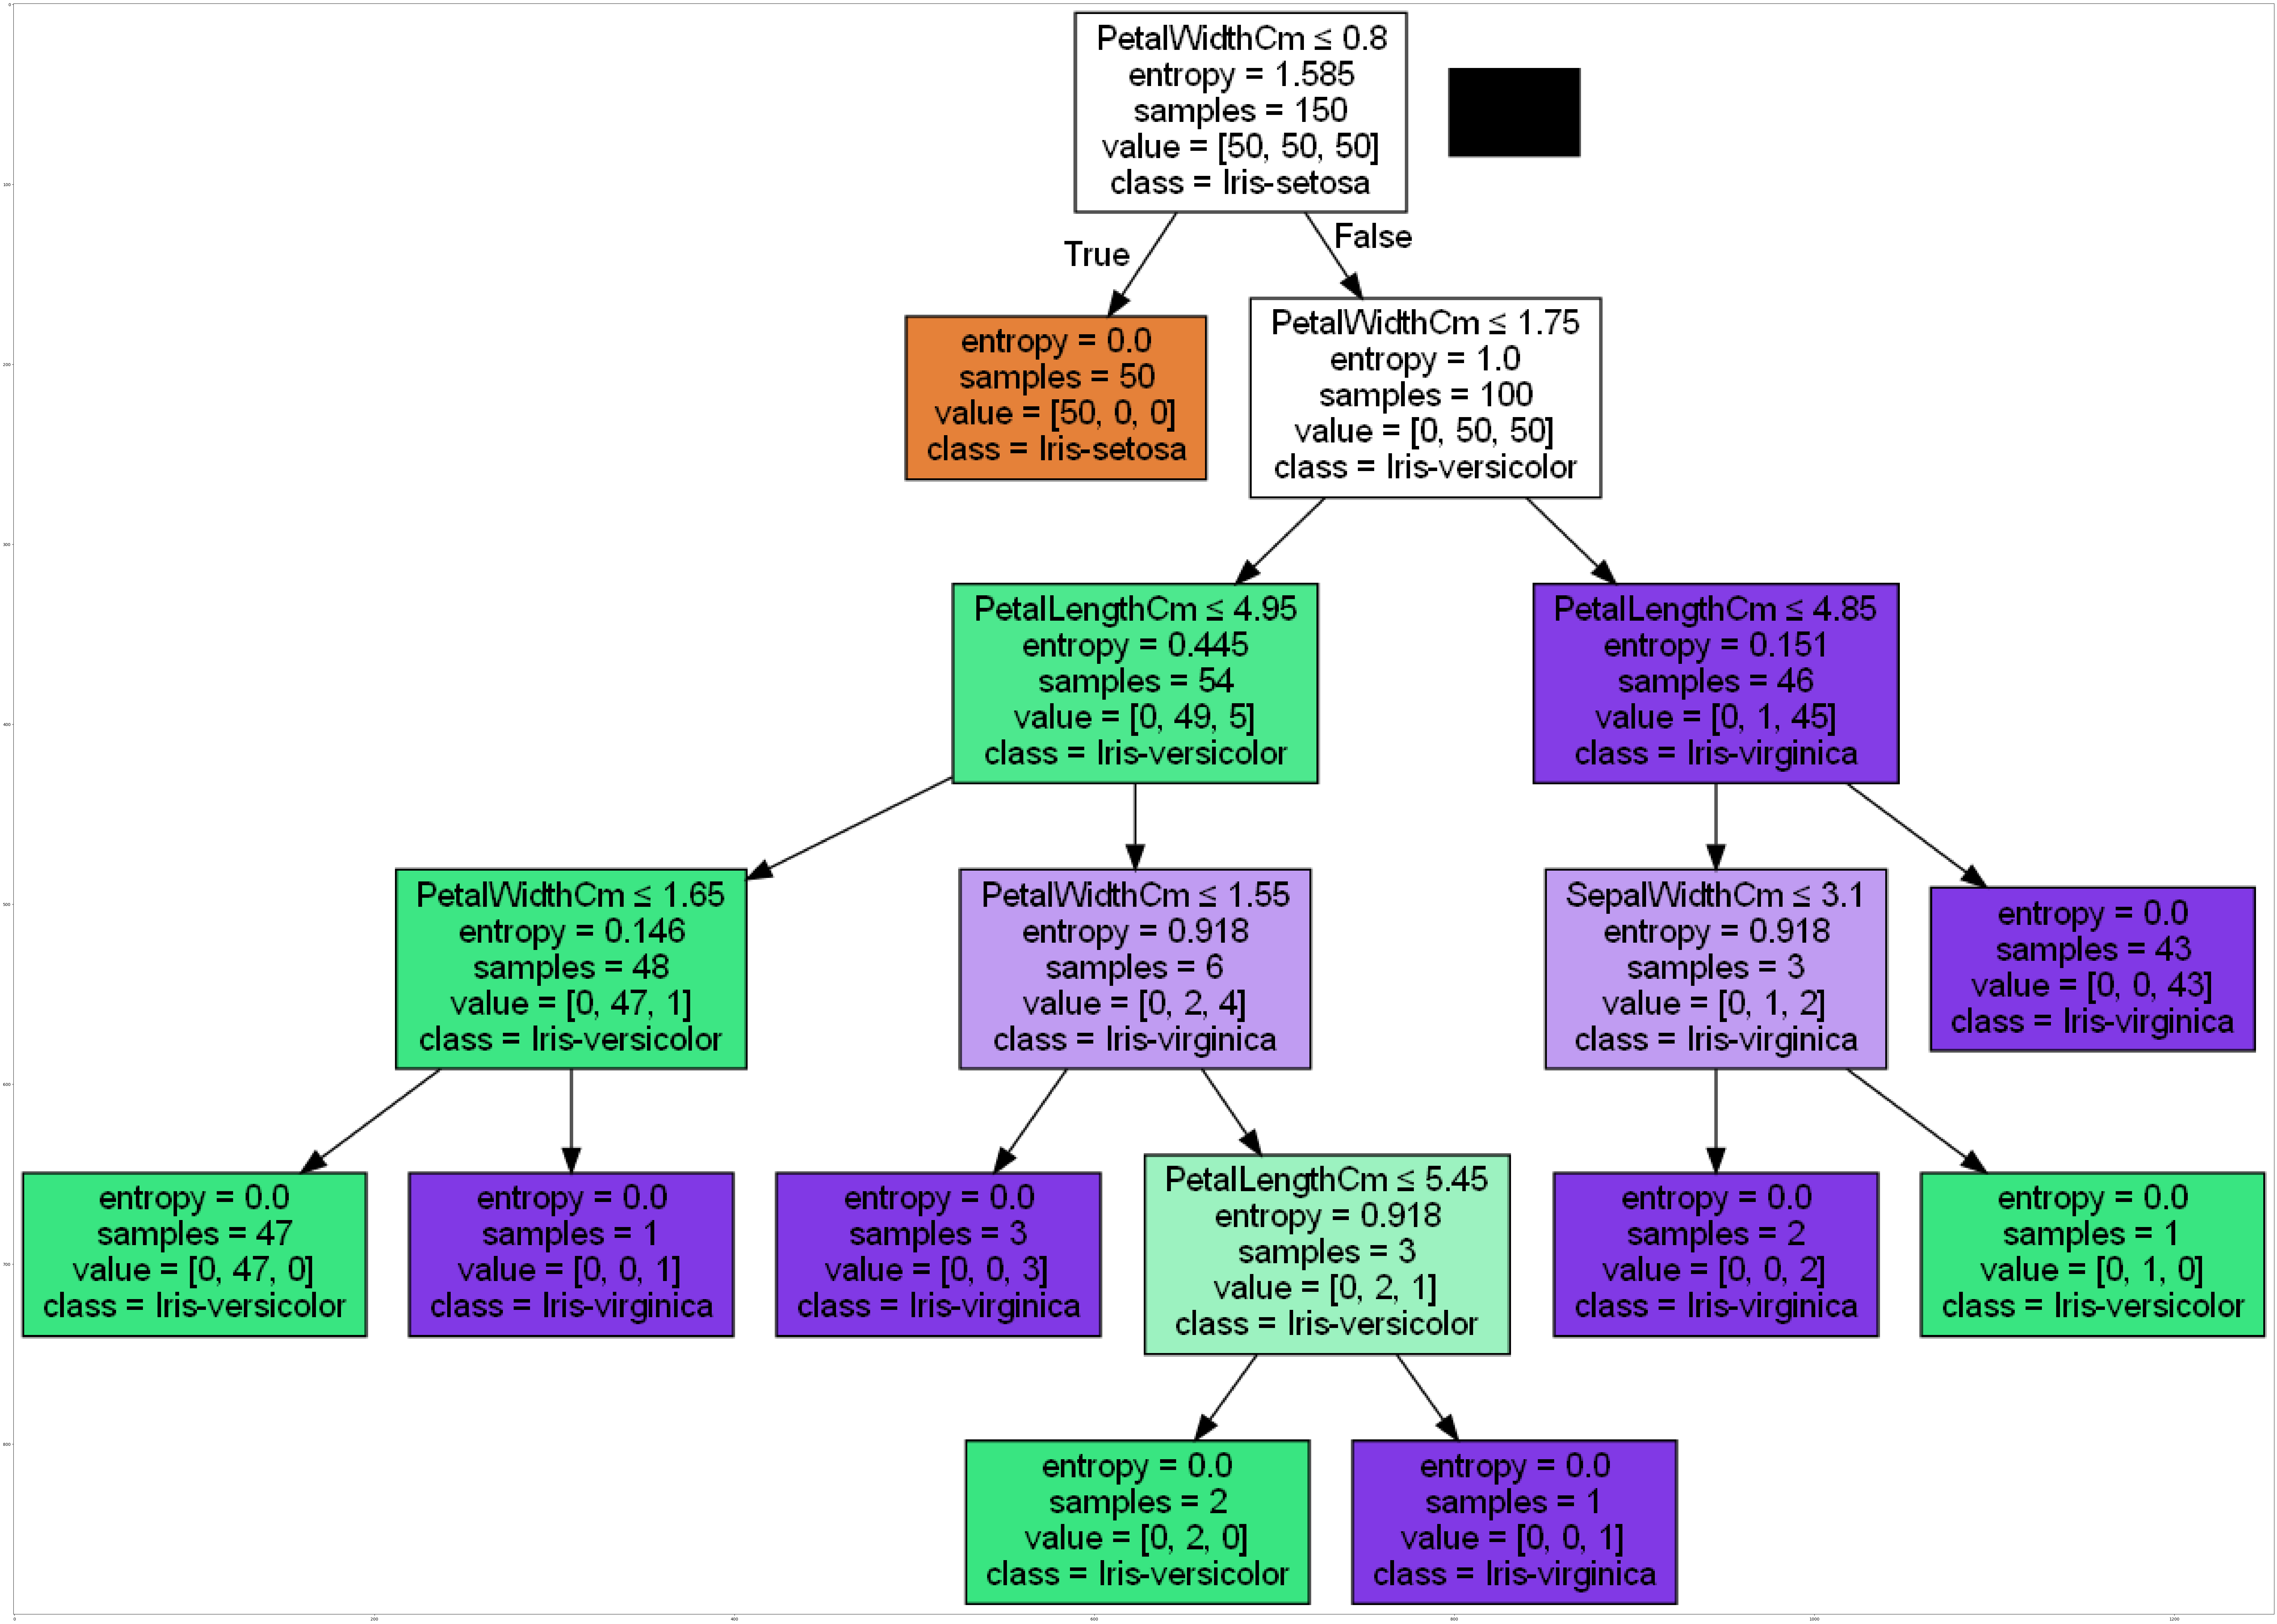

In [5]:
# Visualizacion

from six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 
dot_data = StringIO()
filename = "irisTree.png"
featureNames = df.columns[:-1]
print(featureNames)
targetNames = df["Species"].unique().tolist()
out=tree.export_graphviz(irisTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

Ya visualizado vemos que llegó a la misma conclusión de que PetalWidth y PetalLength llevan a Hojas puras y lo hace primero, luego va separando virginica y versicolor

# Clasificador Bayesiano

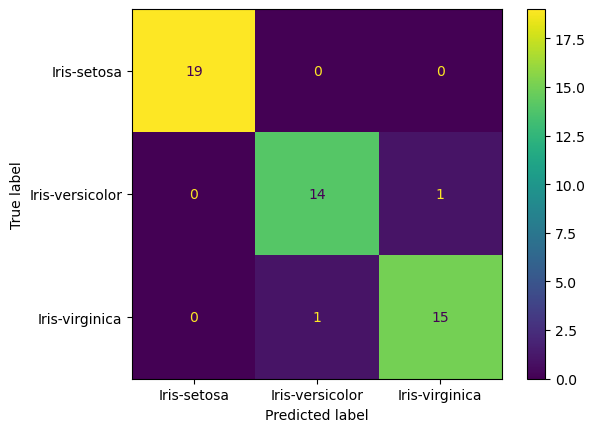

In [58]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

irisBayes = GaussianNB()
irisBayes.fit(X_train, y_train)

y_pred = irisBayes.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=targetNames)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=targetNames)
disp.plot();
